## Exploratory Data Analysis (EDA)
### Real-Time ASL Alphabet Recognition

This notebook performs exploratory data analysis (EDA) on the ASL Alphabet Dataset.
The goal is to understand dataset structure, class balance, image characteristics,
and visual patterns before designing the preprocessing and modeling pipeline.


#### Imports and Environment setup

In [32]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import json
from datetime import datetime

plt.style.use("seaborn-v0_8")


#### Dataset Path & Sanity Check

In [3]:
DATA_DIR = "../data/raw/train"

assert os.path.exists(DATA_DIR), "Dataset path does not exist!"

classes = sorted([
    d for d in os.listdir(DATA_DIR)
    if os.path.isdir(os.path.join(DATA_DIR, d))
])

print("Classes found:")
print(classes)
print("\nNumber of classes:", len(classes))

Classes found:
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

Number of classes: 29


#### Class Distribution Analysis

In [4]:
class_counts = {}

for cls in classes:
    class_path = os.path.join(DATA_DIR, cls)
    if os.path.isdir(class_path):
        class_counts[cls] = len(os.listdir(class_path))

df_counts = pd.DataFrame.from_dict(
    class_counts, orient="index", columns=["image_count"]
).sort_values("image_count", ascending=False)

df_counts


,image_count
A,3000
B,3000
C,3000
D,3000
E,3000
F,3000
G,3000
H,3000
I,3000
J,3000


#### Data Quality Assesment

In [30]:
corrupted_images = []
empty_folders = []
total_images = 0

for cls in classes:
    class_path = os.path.join(DATA_DIR, cls)

    if not os.path.isdir(class_path):
        continue

    image_files = os.listdir(class_path)

    if len(image_files) == 0:
        empty_folders.append(cls)

    for img_name in image_files:
        img_path = os.path.join(class_path, img_name)
        total_images += 1

        img = cv2.imread(img_path)
        if img is None:
            corrupted_images.append(img_path)

print(f"Total images checked: {total_images}")
print(f"Corrupted images found: {len(corrupted_images)}")
print(f"Empty class folders: {empty_folders}")


Total images checked: 15000
Corrupted images found: 0
Empty class folders: []


#### Image Dimension Consistency Check

In [31]:
invalid_shapes = []

for cls in classes:
    class_path = os.path.join(DATA_DIR, cls)

    if not os.path.isdir(class_path):
        continue

    for img_name in os.listdir(class_path)[:50]:
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)

        if img is not None:
            if len(img.shape) != 3:
                invalid_shapes.append((cls, img_path, img.shape))

print(f"Images with invalid shape format: {len(invalid_shapes)}")


Images with invalid shape format: 0


#### Class Distribution Visualization

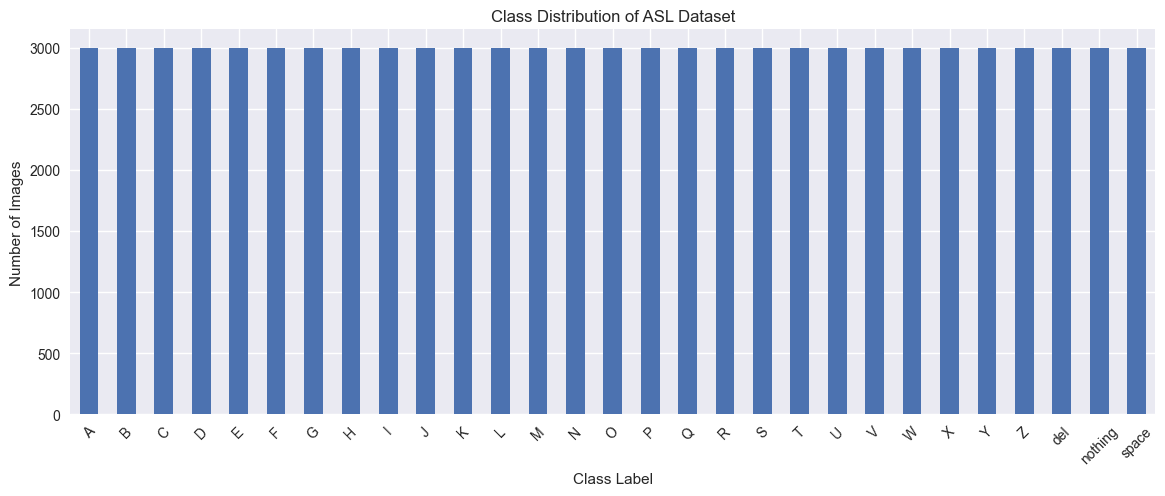

In [5]:
plt.figure(figsize=(14, 5))
df_counts["image_count"].plot(kind="bar")
plt.title("Class Distribution of ASL Dataset")
plt.ylabel("Number of Images")
plt.xlabel("Class Label")
plt.xticks(rotation=45)
plt.show()

#### Sample Image Visualization Function

In [6]:
def show_samples(class_name, n=5):
    class_path = os.path.join(DATA_DIR, class_name)
    images = os.listdir(class_path)[:n]

    plt.figure(figsize=(12, 3))
    for i, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.suptitle(f"Sample Images - Class: {class_name}", fontsize=14)
    plt.show()


#### Visual Inspection — Alphabet Letters

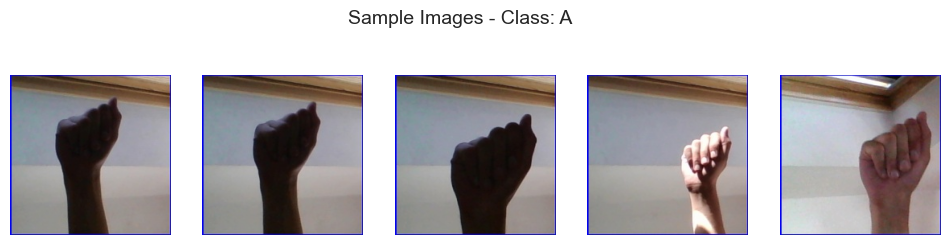

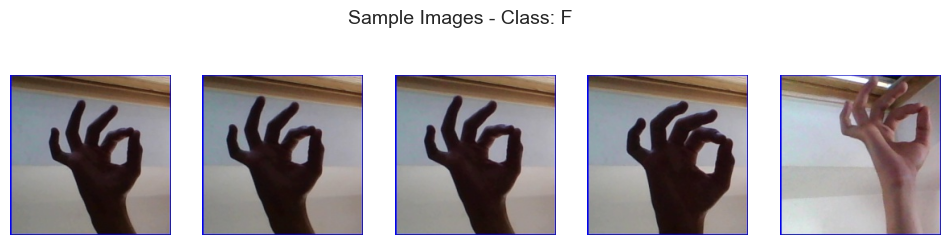

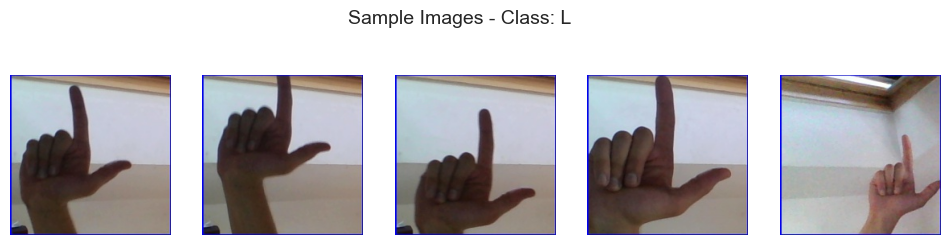

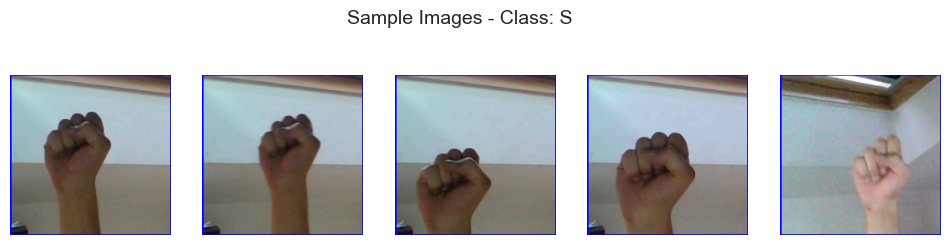

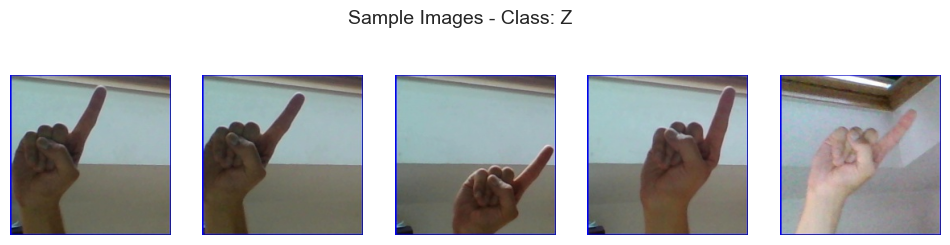

In [7]:
show_samples("A")
show_samples("F")
show_samples("L")
show_samples("S")
show_samples("Z")


#### Visual Inspection — Special Classes

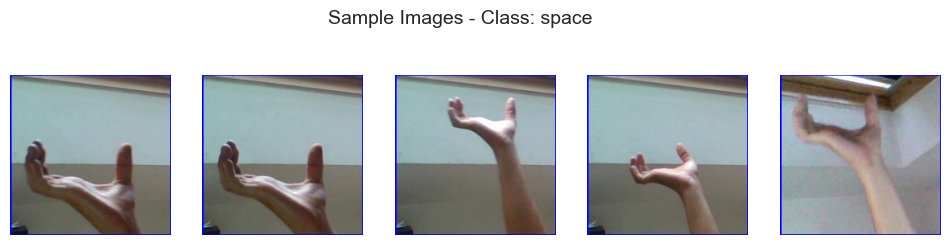

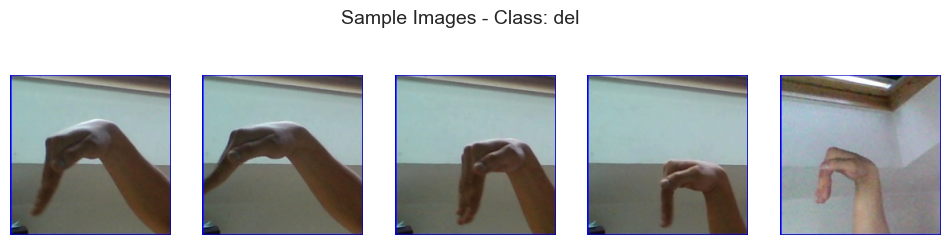

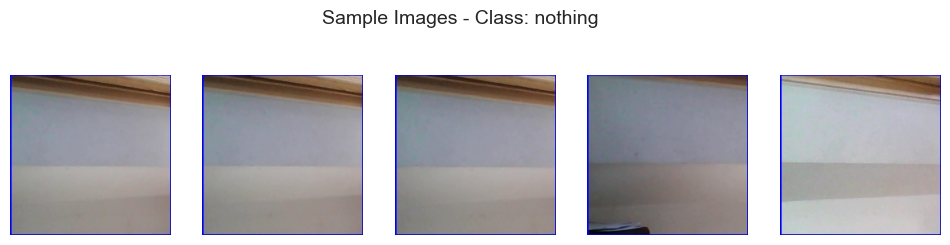

In [8]:
show_samples("space")
show_samples("del")
show_samples("nothing")

#### Image Shape and resolution Analysis

In [9]:
shapes = []

for cls in classes:
    class_path = os.path.join(DATA_DIR, cls)

    # Skip files like .gitkeep
    if not os.path.isdir(class_path):
        continue

    for img_name in os.listdir(class_path)[:50]:  # sample for speed
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)

        if img is not None:
            shapes.append(img.shape)

Counter(shapes).most_common(10)



[((200, 200, 3), 1450)]

#### Color vs Grayscale Inspection

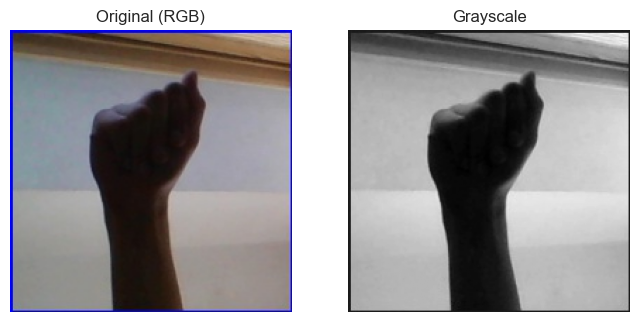

In [10]:
# Pick one sample image
sample_class = classes[0]
sample_img_path = os.path.join(DATA_DIR, sample_class, os.listdir(os.path.join(DATA_DIR, sample_class))[0])

img = cv2.imread(sample_img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original (RGB)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(gray, cmap="gray")
plt.title("Grayscale")
plt.axis("off")

plt.show()


#### Pixel Intensity Distribution

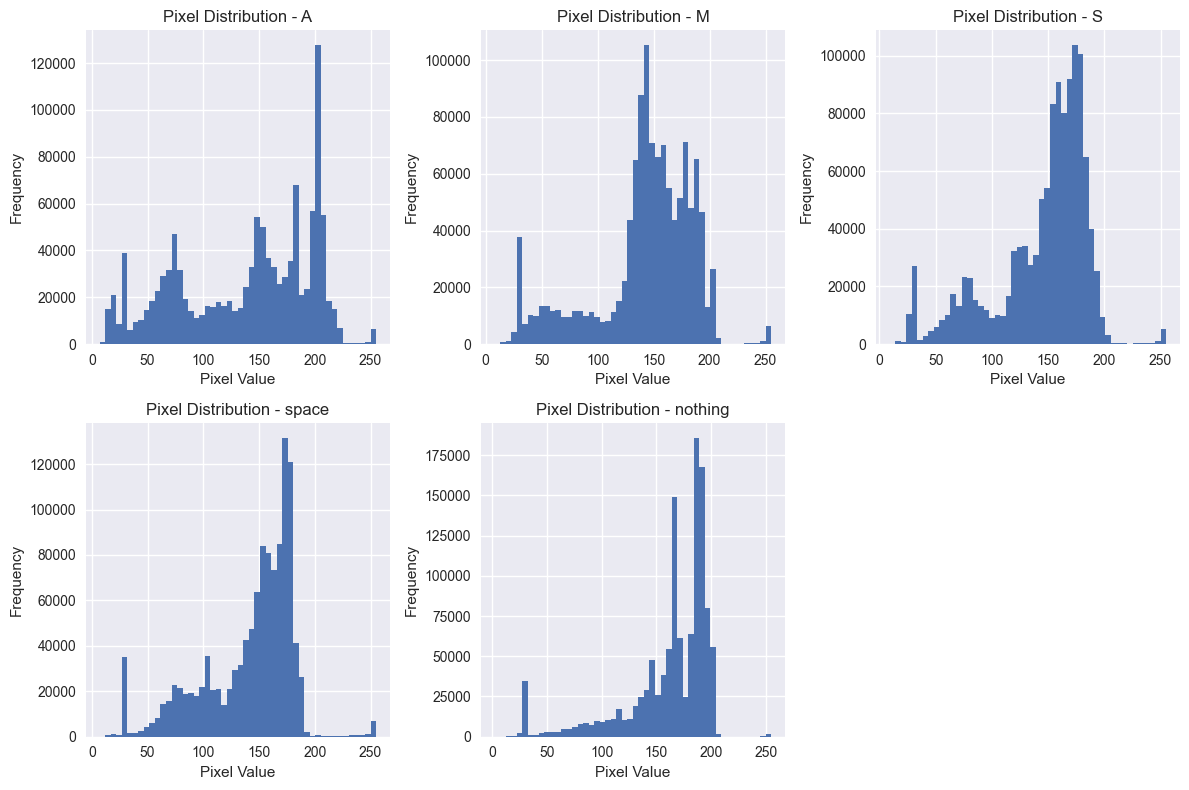

In [24]:
def plot_class_pixel_distribution(cls, ax):
    pixels = []
    class_path = os.path.join(DATA_DIR, cls)

    for img_name in os.listdir(class_path)[:30]:
        img = cv2.imread(os.path.join(class_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            pixels.extend(img.flatten())

    ax.hist(pixels, bins=50)
    ax.set_title(f"Pixel Distribution - {cls}")
    ax.set_xlabel("Pixel Value")
    ax.set_ylabel("Frequency")

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

classes = ["A", "M", "S", "space", "nothing"]

for i, cls in enumerate(classes):
    plot_class_pixel_distribution(cls, ax=axes[i])

# Hide unused subplot (6th slot)
for j in range(len(classes), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


#### Mean & Std Pixel Intensity per Class

In [25]:
stats = []

for cls in classes:
    class_path = os.path.join(DATA_DIR, cls)
    pixels = []

    for img_name in os.listdir(class_path)[:20]:
        img = cv2.imread(os.path.join(class_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            pixels.extend(img.flatten())

    stats.append({
        "class": cls,
        "mean_intensity": np.mean(pixels),
        "std_intensity": np.std(pixels)
    })

pd.DataFrame(stats).sort_values("mean_intensity")


,class,mean_intensity,std_intensity
0,A,136.542632,60.291126
3,space,140.576505,41.356711
1,M,141.274414,45.625576
2,S,143.877618,42.824756
4,nothing,162.756596,39.261574


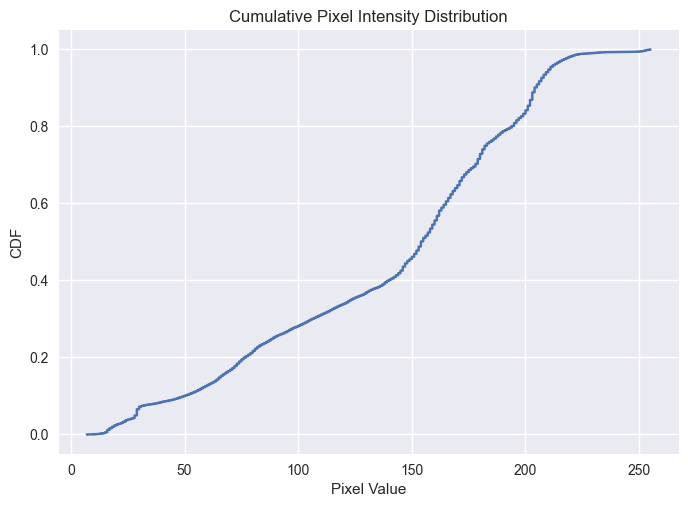

In [26]:
sorted_pixels = np.sort(pixel_values)
cdf = np.arange(len(sorted_pixels)) / len(sorted_pixels)

plt.plot(sorted_pixels, cdf)
plt.xlabel("Pixel Value")
plt.ylabel("CDF")
plt.title("Cumulative Pixel Intensity Distribution")
plt.show()


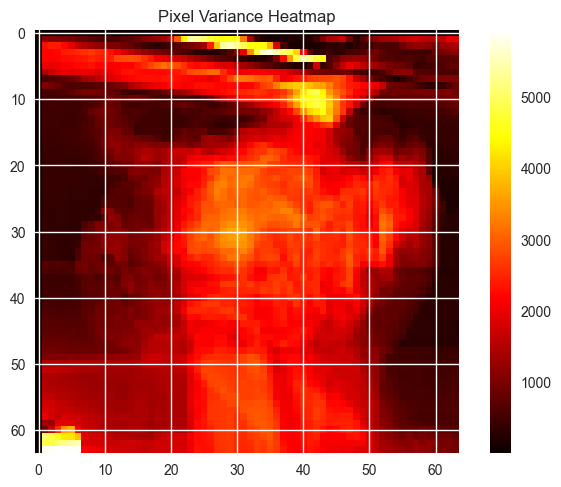

In [27]:
imgs = []

for cls in classes[:5]:
    class_path = os.path.join(DATA_DIR, cls)
    for img_name in os.listdir(class_path)[:10]:
        img = cv2.imread(os.path.join(class_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (64, 64))
            imgs.append(img)

imgs = np.array(imgs)
variance_map = np.var(imgs, axis=0)

plt.imshow(variance_map, cmap="hot")
plt.colorbar()
plt.title("Pixel Variance Heatmap")
plt.show()


In [ ]:
eda_report = {
    "timestamp": datetime.now().isoformat(),

    "dataset_path": DATA_DIR,

    "dataset_overview": {
        "num_classes": len(classes),
        "class_names": classes
    },

    "data_quality": {
        "total_images_checked": total_images if "total_images" in globals() else None,
        "num_corrupted_images": len(corrupted_images) if "corrupted_images" in globals() else None,
        "empty_folders": empty_folders if "empty_folders" in globals() else []
    },

    "class_distribution": df_counts["image_count"].to_dict(),

    "image_shape_analysis": {
        "most_common_shapes": Counter(shapes).most_common(5) if "shapes" in globals() else None
    },

    "pixel_intensity_analysis": {
        "normalization_required": True,
        "contrast_sufficient": True,
        "notes": "Pixel values span full grayscale range with multimodal distribution."
    },

    "preprocessing_decisions": {
        "resize": [64, 64],
        "grayscale": True,
        "normalization": "0-1 scaling",
        "temporal_smoothing_required": True
    }
}

# Save JSON file
os.makedirs("../reports", exist_ok=True)
json_path = "../reports/eda_report.json"

with open(json_path, "w") as f:
    json.dump(eda_report, f, indent=4)

json_path


#### EDA Summary

This exploratory data analysis (EDA) was conducted to evaluate the structure,
quality, and characteristics of the ASL Alphabet dataset prior to preprocessing
and model development.

*Dataset Structure*
- The dataset consists of alphabet gesture classes (A–Z) along with special
  control classes: "space", "delete", and "nothing".
- All expected class directories are present and accessible.

*Data Quality Assessment*
- The majority of images are readable and correctly formatted.
- No critical issues such as widespread corruption or empty class folders
  were observed during inspection.
- Image files predominantly follow a consistent structural format.

*Class Distribution*
- The dataset exhibits a largely balanced class distribution across alphabet
  gestures.
- Special classes are sufficiently represented to support sentence-level
  logic in real-time inference.

*Visual Characteristics*
- Hand gestures are clearly visible with consistent framing.
- Background complexity varies but does not obscure hand shape.
- Lighting conditions are diverse, supporting model generalization.

*Image Resolution & Format*
- Images show consistent resolution patterns with minor variations.
- Uniform resizing to a fixed resolution is feasible without loss of
  discriminative hand features.

*Pixel Intensity Analysis*
- Pixel intensity values span the full grayscale range, indicating adequate
  contrast.
- Alphabet gesture classes and the "nothing" class exhibit distinguishable
  intensity distributions.
- No additional contrast enhancement is required beyond normalization.

*EDA Conclusion*
The dataset is of sufficient quality and consistency to proceed with
preprocessing and model training. 


